# Police API Demo

The https://data.police.uk/docs/ website provides an API — an *application programming interface* — that allows us to write programmatic code that can be used to query and download data from the website directly (that is, at a "machine to machine" level).

A Pyhton package exists that "wraps" this API and allows us to call it from Python code: https://github.com/rkhleics/police-api-client-python ([docs](https://police-api-client-python.readthedocs.io/en/latest/)).

## Using the API

Let's see how to use the API to download all the data for a particular year in a particular policie neighbourhood area.

In [1]:
#Initialisation
from police_api import PoliceAPI
api = PoliceAPI()

In [2]:
#Get forces
forces = api.get_forces()
forces

[<Force> Avon and Somerset Constabulary,
 <Force> Bedfordshire Police,
 <Force> Cambridgeshire Constabulary,
 <Force> Cheshire Constabulary,
 <Force> City of London Police,
 <Force> Cleveland Police,
 <Force> Cumbria Constabulary,
 <Force> Derbyshire Constabulary,
 <Force> Devon & Cornwall Police,
 <Force> Dorset Police,
 <Force> Durham Constabulary,
 <Force> Dyfed-Powys Police,
 <Force> Essex Police,
 <Force> Gloucestershire Constabulary,
 <Force> Greater Manchester Police,
 <Force> Gwent Police,
 <Force> Hampshire Constabulary,
 <Force> Hertfordshire Constabulary,
 <Force> Humberside Police,
 <Force> Kent Police,
 <Force> Lancashire Constabulary,
 <Force> Leicestershire Police,
 <Force> Lincolnshire Police,
 <Force> Merseyside Police,
 <Force> Metropolitan Police Service,
 <Force> Norfolk Constabulary,
 <Force> North Wales Police,
 <Force> North Yorkshire Police,
 <Force> Northamptonshire Police,
 <Force> Northumbria Police,
 <Force> Nottinghamshire Police,
 <Force> Police Service of

Each force has several atributes associated with it.

The items that are returned are a little confusing to work with. Let's make them more directly useable:

In [3]:
def getIdName(records, name=None):
    ''' Get id force by name. If no name, return a dict of name:id mappings. '''
    if name:
        return {r.name:r.id for r in records if name.lower() in r.name.lower()}
    return {r.name:r.id for r in records}

In [4]:
getIdName(forces)

{'Avon and Somerset Constabulary': 'avon-and-somerset',
 'Bedfordshire Police': 'bedfordshire',
 'Cambridgeshire Constabulary': 'cambridgeshire',
 'Cheshire Constabulary': 'cheshire',
 'City of London Police': 'city-of-london',
 'Cleveland Police': 'cleveland',
 'Cumbria Constabulary': 'cumbria',
 'Derbyshire Constabulary': 'derbyshire',
 'Devon & Cornwall Police': 'devon-and-cornwall',
 'Dorset Police': 'dorset',
 'Durham Constabulary': 'durham',
 'Dyfed-Powys Police': 'dyfed-powys',
 'Essex Police': 'essex',
 'Gloucestershire Constabulary': 'gloucestershire',
 'Greater Manchester Police': 'greater-manchester',
 'Gwent Police': 'gwent',
 'Hampshire Constabulary': 'hampshire',
 'Hertfordshire Constabulary': 'hertfordshire',
 'Humberside Police': 'humberside',
 'Kent Police': 'kent',
 'Lancashire Constabulary': 'lancashire',
 'Leicestershire Police': 'leicestershire',
 'Lincolnshire Police': 'lincolnshire',
 'Merseyside Police': 'merseyside',
 'Metropolitan Police Service': 'metropolita

In [5]:
getIdName(forces, 'Hampshire')

{'Hampshire Constabulary': 'hampshire'}

In [6]:
#Get police authority
force = api.get_force('hampshire')


In [7]:
def getNameId(records, rid=None):
    ''' Get record name by id. '''
    if rid:
        return {r.name:r.id for r in records if rid == r.id}
    return {r.name:r.id for r in records}

In [8]:
areas = getNameId(force.neighbourhoods)
areas

{'Aldershot North': '14RA01',
 'Aldershot South': '14RA02',
 'Alton': '8OL01',
 'Alton Rural': '8OL02',
 'Andover East': '11TA04',
 'Andover North': '11TA02',
 'Andover South': '11TA03',
 'Andover Town': '11TA01',
 'Bargate': '2SC02',
 'Barncroft and Bedhampton': '7JH02',
 'Basingstoke Centre': '12BB02',
 'Basingstoke East': '12BB05',
 'Basingstoke North': '12BB03',
 'Basingstoke Rural East': '12BL02',
 'Basingstoke Rural South': '12BL01',
 'Basingstoke Rural West': '12BL03',
 'Basingstoke South': '12BB01',
 'Basingstoke West': '12BB04',
 'Battins and West Leigh': '7JH03',
 'Bevois': '2SC01',
 'Bishops Waltham and Soberton': '9WG02',
 'Bitterne North': '2SN02',
 'Bordon': '8OW02',
 'Butser Clanfield Rowlands Castle': '8OP02',
 'Central Southsea and St Jude': '5PS02',
 'Charles Dickens and Nelson': '5PC01',
 'Cosham': '5PN01',
 'Cowes': '6LW01',
 'Coxford Redbridge Millbrook': '2SW02',
 'Crofton and Titchfield': '3FP01',
 'Denmead and Southwick': '9WG05',
 'East Cowes and Wootton': '6LE

In [9]:
#Show dates available
print( api.get_dates() )

['2019-01', '2018-12', '2018-11', '2018-10', '2018-09', '2018-08', '2018-07', '2018-06', '2018-05', '2018-04', '2018-03', '2018-02', '2018-01', '2017-12', '2017-11', '2017-10', '2017-09', '2017-08', '2017-07', '2017-06', '2017-05', '2017-04', '2017-03', '2017-02', '2017-01', '2016-12', '2016-11', '2016-10', '2016-09', '2016-08', '2016-07', '2016-06', '2016-05', '2016-04', '2016-03', '2016-02']


Via the police API, we can get retrieve a range of information about each neighbourghood.

In [64]:
neighbourhood = force.get_neighbourhood( areas['Ryde'] )
neighbourhood.priorities

[<Neighbourhood.Priority> <p>Violence<br />The North East Wight Team are focusing on reducing Violent Crime, part of this focus will be identifying and protecting persons suffering from domestic abuse.</p>
 
 <p>North East Wight<br />Station Street<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>ASB<br />The North East Wight team are focusing on tackling ASB Related issues, with a particular focus on any area's identified as being subject to drug related harm. </p>
 
 <p>Station Street<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>Burglary<br />The North East Wight Neighbourhood team are focusing on tackling Burglaries in the area. This forms part of an Island wide initiative to reduce Burglaries across the Island. </p>
 
 <p>North East Wight<br />Station Street<br />North East Wight<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>ASB<br />Reduce the speed and noise of vehicle enthusiasts along the

*If we associate output areas with neighbourhoods, we could also use the OA Rural Urban Classification codes to characterise each police neighbourhood.*

To look-up crimes within a particular neighbourhood, we can search within a particular area described by a simple boundary definition list (a closed list of points defining an area).

The data returned by the `get_neighbourhood()` lookup includes a boundary file in the required format for the particular area:

In [10]:
boundary = neighbourhood.boundary

We can plot that boundary using folium if we cast it into the correct form.

In particular, we need to convert the list of lat/lon co-ordinates to a set of lon/lat co-ordinates inside a geojson data structure that folium can work with.

(Getting the correct order for co-ordinates can be a pain, with different packages and formats adopting different conventions. A handy summary can be found [here](https://macwright.org/lonlat/).)

In [11]:
def geoJsonFromNeighbourhoodBoundary(boundary):
    ''' Generate geojson polygon from police API boundary. '''
    geojson = {"type": "FeatureCollection",
               "features": [
                   {
                       "type": "Feature",
                       "properties": {},
                       "geometry": {
                           "type": "Polygon",
                           "coordinates":  [[[ll[1],ll[0]] for ll in boundary]]
                       }
                   }
               ]
              }
    return geojson
#geojson

In [12]:
import folium
import json

m = folium.Map(
    location=boundary[0], #Just pick the first point in boundary to centre map - rough and ready!
    #Note that the default location is in lat/lon order
    tiles='Mapbox Bright',
    zoom_start=11
)

folium.GeoJson(
    geoJsonFromNeighbourhoodBoundary(boundary),
    name='geojson'
).add_to(m)

m

We can easily build up a simple interactive application to allow a user to select a particular neighbourhood from a particular police force area.

In [385]:
#It would be better if this function were a little bit more sensitive to setting bounds on the map viewport
#folium does have a method for this, m.fit_bounds(), that takes bounding box co-ords.
#Generate bounding box from area extrema.
#https://github.com/python-visualization/folium/blob/master/folium/folium.py#L383

def createFoliumMap(boundary):
    m = folium.Map(
        location=boundary[0], #Just pick the first point in boundary to centre map - rough and ready!
        #Note that the default location is in lat/lon order
        #tiles='Mapbox Bright',
        zoom_start=11
    )

    folium.GeoJson(
        geoJsonFromNeighbourhoodBoundary(boundary),
        name='geojson'
    ).add_to(m)

    return m

In [43]:
from ipywidgets import widgets, interact


#Note that we are seeding both widgets with values from the API

force_widget = widgets.Select(options=getIdName(forces),
                              description='Police Force:',
                              disabled=False )

area_widget = widgets.Select(options=getNameId(force.neighbourhoods),
                              description='Neigbourhood areas:',
                              disabled=False )

def update_area_widget(*args):
    ''' Update neighbourhoods widget. Also update the force global variable. '''
    global force
    force = api.get_force(force_widget.value)
    area = getNameId(force.neighbourhoods)
    area_widget.options = getNameId(force.neighbourhoods)
    
force_widget.observe(update_area_widget, 'value')

def mapper(force_i, area_i):
    ''' Generate map for selected area. Also set global boundary for use elsewhere. '''
    global boundary
    neighbourhood = force.get_neighbourhood( area_widget.value )
    boundary = neighbourhood.boundary
    m = createFoliumMap(boundary)
    print(force_i, area_i)
    return m
    
interact(mapper,force_i=force_widget, area_i=area_widget);


interactive(children=(Select(description='Police Force:', options={'Avon and Somerset Constabulary': 'avon-and…

*This sort of thing can be served as a standalone from a notebook source file using things like [voila](https://github.com/QuantStack/voila) or [Jupyter dashboards](https://github.com/jupyter/dashboards). Conversion to [Scripted Forms](https://github.com/SimonBiggs/scriptedforms) format is another option, although that would require a small amount of recoding using Scripted Forms markup.*

## Get crimes in an area

We can use the API to retrieve crimes recorded within a particular area for a particular time period.

In [15]:
crimes = api.get_crimes_area(neighbourhood.boundary, date='2019-01')


In [16]:
#Unpack location details
crimes[0].location.id, crimes[0].location.latitude, crimes[0].location.longitude, crimes[0].location.name


(763767, '50.727222', '-1.162537', 'On or near Supermarket')

In [17]:
#Upack category details
crimes[0].category.id, crimes[0].category.name

('anti-social-behaviour', 'Anti-social behaviour')

In [68]:
import pandas as pd


def setCrimesAsDataFrame(crimes, df=None):
    ''' Convert crimes result to dataframe. '''
    if df is None:
        df=pd.DataFrame(columns = ['cid','type', 'month','name','lid','location','lat','lon'])
        #[int, object, object, int, object, float, float]
    for c in crimes:
        df = df.append({'cid':c.id,'type':c.category.id, 'month':c.month, 'name':c.category.name,
                            'lat':c.location.latitude,'lon':c.location.longitude, 
                        'lid':c.location.id,'location':c.location.name }, ignore_index=True)

    df['lat']=df['lat'].astype(float)
    df['lon']=df['lon'].astype(float)
    
    return df

In [25]:
df = setCrimesAsDataFrame(crimes)
df.head()

,cid,type,month,name,lid,location,lat,lon
0,71249494,anti-social-behaviour,2019-01,Anti-social behaviour,763767,On or near Supermarket,50.727222,-1.162537
1,71249516,anti-social-behaviour,2019-01,Anti-social behaviour,763719,On or near West Place,50.726292,-1.167016
2,71249593,anti-social-behaviour,2019-01,Anti-social behaviour,763566,On or near Sutton Close,50.718427,-1.152494
3,71249583,anti-social-behaviour,2019-01,Anti-social behaviour,763545,On or near Slade Road,50.720485,-1.156055
4,71249466,anti-social-behaviour,2019-01,Anti-social behaviour,763785,On or near George Street,50.728725,-1.161490


## Plot Crimes on Map

As in *Initial Look At The Data.ipynb*, we can plot the crime markers on a map or create a heatmap.

In [26]:
#Recall that the Heatmap plugin expects data in the form [[Latitude, Longitude, count], ...]

data = df.groupby(['lat','lon']).size().reset_index().values.tolist()
data[:3]

[[50.716306, -1.151484, 3.0],
 [50.718427, -1.152494, 4.0],
 [50.719642, -1.147698, 1.0]]

In [30]:
from folium.plugins import HeatMap

m = folium.Map(data[0][:2], zoom_start=12)


HeatMap(data).add_to(m)

m

We can then select an area, and crime type, to generate a heatmap from:

In [42]:
crime_types = df[['name','type']].drop_duplicates().set_index('name')['type'].to_dict()
crime_types

{'Anti-social behaviour': 'anti-social-behaviour',
 'Bicycle theft': 'bicycle-theft',
 'Burglary': 'burglary',
 'Criminal damage and arson': 'criminal-damage-arson',
 'Drugs': 'drugs',
 'Other theft': 'other-theft',
 'Public order': 'public-order',
 'Robbery': 'robbery',
 'Shoplifting': 'shoplifting',
 'Violence and sexual offences': 'violent-crime',
 'Other crime': 'other-crime'}

For now, let's just use a fixed date. We could of course add in another widget to select the date too.

In [97]:
crime_widget = widgets.Select(options=crime_types,
                              description='Crime:',
                              disabled=False )


def crime_heatmap(force_i, area_i, crime_i):
    ''' Create a heatmap. '''
    m = mapper(force_i, area_i)
    
    crimes = api.get_crimes_area(boundary, date='2019-01')
    df = setCrimesAsDataFrame(crimes)
    df = df[df['type']==crime_i]
    data = df.groupby(['lat','lon']).size().reset_index().values.tolist()

    HeatMap(data).add_to(m)
    
    return m



interact(crime_heatmap,force_i=force_widget, area_i=area_widget, crime_i=crime_widget);


interactive(children=(Select(description='Police Force:', options={'Avon and Somerset Constabulary': 'avon-and…

Or we can create a heatmap that is animated over several time periods.

To do this, we first need to obtain crime data recorded over several different months:

In [46]:
dates_2018 = [d for d in api.get_dates() if '2018' in d]
dates_2018

['2018-12',
 '2018-11',
 '2018-10',
 '2018-09',
 '2018-08',
 '2018-07',
 '2018-06',
 '2018-05',
 '2018-04',
 '2018-03',
 '2018-02',
 '2018-01']

We could collect the data into a single dataframe as:

In [49]:
crimes_2018= pd.DataFrame()

for d in dates_2018:
    tmp = api.get_crimes_area(boundary, date=d)
    crimes_2018 = pd.concat([crimes_2018, setCrimesAsDataFrame(tmp)])
    
crimes_2018.head()

,cid,type,month,name,lid,location,lat,lon
0,70393460,anti-social-behaviour,2018-12,Anti-social behaviour,776327,On or near Benhams Road,50.929404,-1.356801
1,70393473,anti-social-behaviour,2018-12,Anti-social behaviour,776327,On or near Benhams Road,50.929404,-1.356801
2,70392556,anti-social-behaviour,2018-12,Anti-social behaviour,774803,On or near Steuart Road,50.917144,-1.381210
3,70392199,anti-social-behaviour,2018-12,Anti-social behaviour,774677,On or near Bramwell Court,50.913537,-1.352738
4,70393427,anti-social-behaviour,2018-12,Anti-social behaviour,776304,On or near Middleton Close,50.927950,-1.357333


However, the data needs to be presented as a list of lists: `[ data_period1, data_period2, etc. ]`.

So it may be easier (for now) to collect it as:

In [56]:
overall_data = []

for d in dates_2018:
    tmp_crimes = api.get_crimes_area(boundary, date=d)
    df = setCrimesAsDataFrame(tmp_crimes)
    period_data = df.groupby(['lat','lon']).size().reset_index().values.tolist()
    overall_data.append(period_data)

In [58]:
from folium.plugins import HeatMapWithTime

m = folium.Map(overall_data[0][0][:2], tiles='stamentoner', zoom_start=13)

HeatMapWithTime(overall_data).add_to(m)

m

## Plotting Choropleths

Another way of visualising the data is to use a choropleth map. However, this requires boundaries, rather than points, that can be filled with indicative colour values.

The Police API allows us to search for crimes within a particular boundary, so we could download shapefiles for a small geography (for example, [output area](http://geoportal.statistics.gov.uk/datasets/09b8a48426e3482ebbc0b0c49985c0fb_0)) and search for crimes withon those areas.

An alternative is to generate Voronoi boundaries around each of the crime points. (Ideally, we would have a database of all the legitimate crime recording points in a neighbourhood. (Locations are approximated to specific location points.))

There are several ways in which we can generate Voronoi boundaries (*notebook to follow*), but for convenience we will use the [WZBSocialScienceCenter/geovoronoi](https://github.com/WZBSocialScienceCenter/geovoronoi/) package.

*ASIDE: [spatialite will create voronoi boundaries](https://www.gaia-gis.it/fossil/libspatialite/wiki?name=tesselations-4.0); other py examples with a lower level look can be found [here](https://gist.github.com/Sklavit/e05f0b61cb12ac781c93442fbea4fb55), [here](https://github.com/GrayTaylor/voronoi/blob/master/Voronoi%20for%20tableau.ipynb) and [here](https://stackoverflow.com/questions/23901943/voronoi-compute-exact-boundaries-of-every-region/52727406#52727406).*

One of the example recipes for using the `geovoronoi` packages works on a geopandas dataframe, so let's convert the crimes dataframe to a geopandas dataframe.

*(The recipe actually converts co-ordinates in the geodataframe representation back to an array that is closer to our original list of points, but it is nevertheless instructive to show how we can generate a geopandas dataframe.)*

In [141]:
#For a particular crime type, get the count of crimes by location
crimes = setCrimesAsDataFrame( api.get_crimes_area(boundary, date='2019-01') )
public_order_crime = crimes[crimes['type']=='public-order']
public_order_crime_count_by_location = public_order_crime.groupby(['lat','lon']).size().to_frame('Count').reset_index()
public_order_crime_count_by_location.head()

,lat,lon,Count
0,50.905766,-1.391004,1
1,50.908768,-1.397479,1
2,50.909429,-1.393246,2
3,50.909940,-1.389427,1
4,50.910711,-1.399516,1


In [357]:
#For convenience, let's go back to using the df name...
df = public_order_crime_count_by_location.reset_index()

Cast the dataframe as a geodataframe with a suitable geometry column:

In [373]:
#https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
import geopandas
from shapely.geometry import Point

df['Coordinates'] = list(zip(df['lon'], df['lat']))
df['Coordinates'] = df['Coordinates'].apply(Point)

df['RCoordinates'] = list(zip(df['lat'], df['lon']))
df['RCoordinates'] = df['RCoordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')

#Avoid ambiguity about whether index is int or string
gdf['index'] = gdf['index'].apply(lambda x: 'a_{}'.format(x))

gdf.head()

,index,lat,lon,Count,Coordinates,RCoordinates,voronoi_boundary
0,a_0,50.905766,-1.391004,1,POINT (-1.391004 50.905766),POINT (50.905766 -1.391004),POLYGON ((-1.403794612501743 50.91824480571032...
1,a_1,50.908768,-1.397479,1,POINT (-1.397479 50.908768),POINT (50.908768 -1.397479),POLYGON ((-1.400667122044089 50.91784738296978...
2,a_2,50.909429,-1.393246,2,POINT (-1.393246 50.909429),POINT (50.909429 -1.393246),POLYGON ((-1.400667122044089 50.91784738296978...
3,a_3,50.909940,-1.389427,1,POINT (-1.389427 50.90994),POINT (50.90994 -1.389427),"POLYGON ((-1.39446924386208 50.91454443252438,..."
4,a_4,50.910711,-1.399516,1,POINT (-1.399516 50.910711),POINT (50.910711 -1.399516),POLYGON ((-1.391828404158418 50.92004831759458...


In [374]:
gdf.crs = {'init' :'epsg:4326 '}
gdf.crs

{'init': 'epsg:4326 '}

We also need the boundary as a shapefile:

In [375]:
#Check how the boundary co-ordinates are presented
boundary[:2]
#Looks like: lat, lon

[(50.918888188227, -1.3887913614074), (50.918581802548, -1.3894253024958)]

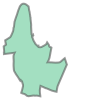

In [376]:
from shapely import geometry

#By default, I think shapely shapes assume lon/lat format...
#So this shape is rotated in preview...
boundary_shape_rotated = geometry.Polygon(boundary)
boundary_shape_rotated

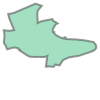

In [377]:
boundary_shape = geometry.Polygon( [(lon,lat) for (lat,lon) in boundary] )
boundary_shape

Now let's see how to create the Voronoi boundaries

In [378]:
#https://github.com/WZBSocialScienceCenter/geovoronoi/blob/master/examples/using_geopandas.py

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords


# convert the pandas Series of Point objects to NumPy array of coordinates
coords = points_to_coords(gdf.Coordinates)
Rcoords = points_to_coords(gdf.RCoordinates)

# Calculate the Voronoi regions for the identifed points and then 
# clip within the geographic area shape
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, boundary_shape)


INFO:geovoronoi:running Voronoi tesselation for 19 points
INFO:geovoronoi:generated 19 Voronoi regions
INFO:geovoronoi:generating Voronoi polygon lines
INFO:geovoronoi:generating Voronoi polygon shapes
INFO:geovoronoi:assigning 19 points to 19 Voronoi polygons


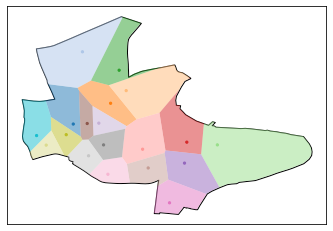

In [379]:
#Preview the shapes

fig, ax = subplot_for_map()

plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments);


The `polyshapes` object is a list of boundaries for the Voronoi areas, associated with particular points. In general, we might have multiple rows in the original table associated with each shape (the mappings are decribed as a list in `poly_to_pt_assignments`) but in this case we ensured unique locations in the dataframe. 

The Voronoi shaper returns items in the same order they were presented, so we can merge the data back:

In [380]:
gdf['voronoi_boundary'] = poly_shapes

gdf = gdf.set_geometry('voronoi_boundary')

gdf.head()

,index,lat,lon,Count,Coordinates,RCoordinates,voronoi_boundary
0,a_0,50.905766,-1.391004,1,POINT (-1.391004 50.905766),POINT (50.905766 -1.391004),POLYGON ((-1.403794612501743 50.91824480571032...
1,a_1,50.908768,-1.397479,1,POINT (-1.397479 50.908768),POINT (50.908768 -1.397479),POLYGON ((-1.400667122044089 50.91784738296978...
2,a_2,50.909429,-1.393246,2,POINT (-1.393246 50.909429),POINT (50.909429 -1.393246),POLYGON ((-1.400667122044089 50.91784738296978...
3,a_3,50.909940,-1.389427,1,POINT (-1.389427 50.90994),POINT (50.90994 -1.389427),"POLYGON ((-1.39446924386208 50.91454443252438,..."
4,a_4,50.910711,-1.399516,1,POINT (-1.399516 50.910711),POINT (50.910711 -1.399516),POLYGON ((-1.391828404158418 50.92004831759458...


We should now be able to plot this as a choropleth map:

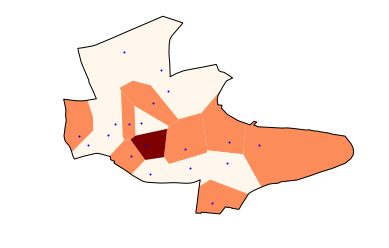

In [381]:
from descartes import PolygonPatch

ax = gdf.plot(column='Count', cmap='OrRd')
ax.add_patch(PolygonPatch(boundary_shape,fill=False))

gdf = gdf.set_geometry('Coordinates')
gdf[gdf['Count']>0].plot( ax=ax, markersize=1, c='b', marker='o')
ax.axis('off');

The shapes defined in geojson have to be just right for it to be plotted correctly.

It seems that the shapes returned by the `voronoi_regions_from_coords()` don't play nicely with folium, so if we want to plot them in folium we need to repair the geojson that the geodataframe `__geo_interface__` returns.

The following seems to do the trick...

In [383]:
import json
from geojson_rewind import rewind

gdf = gdf.set_geometry('voronoi_boundary')
rewoundGeoJSON = rewind( json.dumps(gdf.set_index('index')['voronoi_boundary'].__geo_interface__) )

In [399]:
def addMarker(m,row):
    folium.Circle([row['lat'], row['lon']], radius=1, color='red').add_to(m)
    
m =  folium.Map(zoom_start=12, location=[50.905766, -1.391004])
folium.Choropleth(rewoundGeoJSON,#gdf[['index','Count','voronoi_boundary']],
                  key_on='id',
                  data=gdf, 
                  columns=['index','Count'],
            fill_color='YlOrBr').add_to(m)

#for i, r in gdf.iterrows():
#    folium.Circle([r['lat'], r['lon']], radius=1, color='red').add_to(m)
gdf.apply(lambda x: addMarker(m,x), axis=1)
m

In [ ]:
# TO DO

# Show how we can create maps for areas using widget selectors

In [370]:
rewoundGeoJSON

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-1.4037946125017426, 50.91824480571032], [-1.4034585309062, 50.917528443943], [-1.4031091633632, 50.9167038491], [-1.4040287717879696, 50.91655179869177], [-1.4034776071119648, 50.914798258270416], [-1.400339362298744, 50.91272477509024], [-1.4005217407443045, 50.91758598965707], [-1.4006671220440887, 50.91784738296978], [-1.4037946125017426, 50.91824480571032]]]}, "bbox": [-1.4040287717879696, 50.91272477509024, -1.400339362298744, 50.91824480571032]}, {"id": "1", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-1.4006671220440887, 50.91784738296978], [-1.3992598617652878, 50.918617201935824], [-1.3959035715175236, 50.925307245358404], [-1.3961161032388, 50.92537710882], [-1.3961203481189, 50.925378929251], [-1.3970346339017, 50.924983487112], [-1.3975940800867, 50.924740878991], [-1.3982979888984, 50.9244

In [372]:
gdf.dtypes

index                 int64
lat                 float64
lon                 float64
Count                 int64
Coordinates          object
RCoordinates         object
voronoi_boundary     object
dtype: object